In [2]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

from mne.viz import plot_compare_evokeds

import numpy as np 

import os 
from andante_pd_ft2mne import import2mne  

matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


Test on all subjects 
--

In [3]:
datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

if not(os.path.isdir('timegen_controls_wholeepoch')):
    print('Making probands timegen dir ')
    os.mkdir('timegen_controls_wholeepoch')

if not(os.path.isdir('timegen_patients_wholeepoch')):
    print('Making patients timegen dir ')
    os.mkdir('timegen_patients_wholeepoch')

In [84]:
from scipy.stats import mannwhitneyu

def mann_witt_matrix(mat,y):
    lcol = mat.shape[1]
    pvalue = np.zeros((lcol,lcol))
    statU = np.zeros((lcol,lcol))
    probav = np.zeros((2,lcol,lcol))
    unik = (np.unique(y))
    valstd=  unik[0]
    valdev= unik[1]
    for i in range(lcol):
        for j in range(lcol):
            #curp_S=mat[:,i,j,0]
            #curp_D=mat[:,i,j,1]
            curp_S_S=mat[(y==valstd),i,j,0]
            curp_S_D=mat[(y==valdev),i,j,0]
            
            stat,pval = mannwhitneyu(curp_S_S,curp_S_D,alternative='two-sided')
            statU[i,j]=stat
            pvalue[i,j]=pval
            
            probav[0,i,j]= np.mean(curp_S_S,axis=0)
            probav[1,i,j]= np.mean(curp_S_D,axis=0)
    
    return statU,pvalue,probav
            
def mann_witt_all(bigmat,y):
    resU = []
    resP = []
    resprobav = []
    for mat in bigmat:
        U,pval,probav = mann_witt_matrix(mat,y)
        
        resU.append(U)
        resP.append(pval)
        resprobav.append(probav)
        
    return np.stack(resU),np.stack(resP),np.stack(resprobav)

In [85]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator
from mne.decoding import CSP

from sklearn.model_selection import StratifiedKFold


def timegen_process_2x2(matfile,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    clf = make_pipeline(StandardScaler(),LogisticRegression())

    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=1)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=1)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []
    scores2_1 = []
    scores2_2 = []
    
    proba1_1 = []
    proba1_2 = []
    proba2_1 = []
    proba2_2 = []
    
    U1_1 = []
    U1_2 = []
    U2_1 = []
    U2_2 = []
    
    allpval1_1=[]
    allpval1_2=[]
    allpval2_1=[]
    allpval2_2=[]

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=epochs[train].get_data(), y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=epochs_cond2[train2].get_data(), y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba1_1.append(proba_av)
            U1_1.append(U)
            allpval1_1.append(allpval)
            
            
            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba1_2.append(proba_av)
            U1_2.append(U)
            allpval1_2.append(allpval)
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba2_1.append(proba_av)
            U2_1.append(U)
            allpval2_1.append(allpval)
            
            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba2_2.append(proba_av)
            U2_2.append(U)
            allpval2_2.append(allpval)

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    proba1_1 = np.stack(proba1_1)
    
    proba1_2 = np.stack(proba1_2)
    
    proba2_1 = np.stack(proba2_1)
    
    proba2_2 = np.stack(proba2_2)
    
    U1_1 = np.stack(U1_1)
    U1_2 = np.stack(U1_2)
    U2_1 = np.stack(U2_1)
    U2_2 = np.stack(U2_2)
    
    allpval1_1 = np.stack(allpval1_1)
    allpval1_2 = np.stack(allpval1_2)
    allpval2_1 = np.stack(allpval2_1)
    allpval2_2 = np.stack(allpval2_2)
    
    scores = np.stack([scores1_1,scores1_2,scores2_1,scores2_2])
    allU = np.stack([U1_1,U1_2,U2_1,U2_2])
    allpvals = np.stack([allpval1_1,allpval1_2,allpval2_1,allpval2_2])
    allproba = np.stack([proba1_1,proba1_2,proba2_1,proba2_2])
     
    return scores,allU,allpvals,allproba,epochs.times[[0, -1, 0, -1]]

Formal structure

test

In [90]:
temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']

tmin = -0.05
tmax = 0.52
ncv  = 2

#tmin = 0.25
#tmax = 0.40
#ncv  = 2

allscores_formal = []
allproba_formal = []

allU_formal = []
allpval_formal= []

listofsubj = [allcontrols,allpatients]

savenpz = True

for kk,group in enumerate(['probands','patients']):

    curlist = listofsubj[kk]
    
    for matfile in curlist[1:]:
        curfile = os.path.join(datadir,group,matfile)
        subjid = curfile[-8:-4]

        allscores,allU,allpvals,allproba,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                                 ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)
        
       

        if savenpz:
            np.savez_compressed(os.path.join('alldata_proba',"180523_%s_formal_conditionwise.npz" % subjid),
                                scores=allscores,
                                proba = allproba,
                                U = allU,
                                pval=allpvals)

Subject : 02k1 
612 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03k1 
621 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 04k1 
670 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 05k1 
613 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 06k1 
562 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 07k1 
631 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 08k1 
587 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 09k1 
574 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 10k1 
671 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 11k1 
679 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 12k1 
685 matching events found
0 projection items activated
0 bad epo

In [87]:
timepoints

array([ 0.25000001,  0.40000002,  0.25000001,  0.40000002])

In [76]:
def plot_2x2(matfile,scores1_1,scores1_2,scores2_1,scores2_2,timepoints,metric='accuracy',tmin=-0.05,tmax=0.15,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev']):
    
    subjid = matfile[-8:-4]
    
    ## Open file 
    mneEpochs = import2mne(matfile)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)
    
    
    #Plot
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    axes_order = [(1,0),(1,1),(0,0),(0,1)]
    
    
    yaxis_names = ['Training Regular','','Training Irregular','']
    xaxis_names = ['Testing Regular','Testing Irregular','','']

    
    for cur_ind,scores in enumerate([scores1_1,scores1_2,scores2_1,scores2_2]):
    
        cur_ax = axes[axes_order[cur_ind]]
        
        im = cur_ax.matshow(scores.mean(axis=0), cmap='RdBu_r', vmin=0.3,vmax=0.7,origin='lower',
                    extent=timepoints)

        cur_ax.axhline(0., color='k')
        cur_ax.axvline(0., color='k')
        cur_ax.xaxis.set_ticks_position('bottom')
        cur_ax.set_xlabel(xaxis_names[cur_ind])
        cur_ax.set_ylabel(yaxis_names[cur_ind])
        #titlestring = sprintf("%s - %s \n %s vs %s",subjid,metric,condnames[0],condnames[1])
        #cur_ax.set_title('%s - %s - \n %s vs %s' % (subjid,metric,allcondnames[(0+2*cur_ind)%4],allcondnames[(2*cur_ind+1)%4]))
        #cur_ax.set_title('%d' % cur_ind)
        #plt.colorbar(im, ax=cur_ax)
    
    """## Plot the ERP """
    """
    colors = ['Crimson','CornFlowerBlue']

    pick = mneEpochs_short.ch_names.index('Cz')
    
    
    conditions = condnames

    evoked_dict = dict()
    for condition in conditions:
        evoked_dict[condition] = mneEpochs_short[condition].average()
        

    plot_compare_evokeds(evoked_dict,colors=colors,picks=pick,axes=axes[1,2])
    
    
    conditions2 = condnames_2

    evoked_dict2 = dict()
    for condition in conditions2:
        evoked_dict2[condition] = mneEpochs_short[condition].average()

    plot_compare_evokeds(evoked_dict2,colors=colors,picks=pick,axes=axes[0,2])

    

    """
    fig.subplots_adjust(wspace=0.1)
    
    return fig

In [113]:
if not(os.path.isdir('timegen_controls_conditionwise')):
    print('Making probands conditionwise dir ')
    os.mkdir('timegen_controls_conditionwise')

for jj,matfile in enumerate(allcontrols):
    curfile = os.path.join(datadir,'probands',matfile)
    subjid = curfile[-8:-4]
    
    
    fig= plot_2x2(curfile,allscores_formal[jj,0],allscores_formal[jj,1],allscores_formal[jj,2],allscores_formal[jj,3],
                  timepoints,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             condnames=formal_iso,condnames_2=formal_rnd)
    
    
    fig.set_size_inches([8.,8.])
    fig.savefig('timegen_controls_conditionwise/%s_formal.png' % subjid)
    plt.close(fig)

657 matching events found
0 projection items activated
0 bad epochs dropped
612 matching events found
0 projection items activated
0 bad epochs dropped
621 matching events found
0 projection items activated
0 bad epochs dropped
670 matching events found
0 projection items activated
0 bad epochs dropped
613 matching events found
0 projection items activated
0 bad epochs dropped
562 matching events found
0 projection items activated
0 bad epochs dropped
631 matching events found
0 projection items activated
0 bad epochs dropped
587 matching events found
0 projection items activated
0 bad epochs dropped
574 matching events found
0 projection items activated
0 bad epochs dropped
671 matching events found
0 projection items activated
0 bad epochs dropped
679 matching events found
0 projection items activated
0 bad epochs dropped
685 matching events found
0 projection items activated
0 bad epochs dropped
633 matching events found
0 projection items activated
0 bad epochs dropped
637 matching

In [115]:
if not(os.path.isdir('timegen_patients_conditionwise')):
    print('Making patients conditionwise dir ')
    os.mkdir('timegen_patients_conditionwise')

allscores_formal_pat = []

for matfile in allpatients:
    curfile = os.path.join(datadir,'patients',matfile)
    subjid = curfile[-8:-4]
    
    sc1_1,sc1_2,sc2_1,sc2_2,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd)
    
    fig= plot_2x2(curfile,sc1_1,sc1_2,sc2_1,sc2_2,
                  timepoints,metric='roc_auc',tmin=tmin,tmax=tmax,
                                             condnames=formal_iso,condnames_2=formal_rnd)
    
    
    fig.set_size_inches([8.,8.])
    fig.savefig('timegen_patients_conditionwise/%s_formal.png' % subjid)
    plt.close(fig)
    
    
    allscores_formal_pat.append([sc1_1,sc1_2,sc2_1,sc2_2])

allscores_formal_pat = np.stack(allscores_formal_pat)

np.savez_compressed("180513_allscores_formal_patients_conditionwise.npz",allscores_formal=allscores_formal_pat)

Subject : 01c1 
632 matching events found
0 projection items activated
0 bad epochs dropped
632 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 01m1 
566 matching events found
0 projection items activated
0 bad epochs dropped
566 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 02c1 
577 matching events found
0 projection items activated
0 bad epochs dropped
577 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 02m1 
608 matching events found
0 projection items activated
0 bad epochs dropped
608 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03c1 
639 matching events found
0 projection items activated
0 bad epochs dropped
639 matching events found
0 projection items activated
0 bad epochs dropped
Subject : 03m1 
654 matching events found
0 projection items activated
0 bad epochs dropped
654 matching events found
0 projection items activated
0 bad epochs 

method from [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3903480/)
--
To compute the average duration over which temporal generalization remained significant, we computed the number of time samples during which each classifier could significantly predict the trials' classes, using false discovery rate (FDR) to correct for multiple comparison. To avoid underestimating the mean generalization time, we only considered the time window during which the diagonal classifiers performed above chance (82 ms–450 ms).

Statistics & Effect sizes
To test for statistical significance within subjects, Mann-Whitney U tests were performed on the classifiers' continuous outputs, with trials as the random variable. Similarly, across-subjects statistics were performed using Wilcoxon Signed Rank Tests. Effect sizes are summarized with the AUC computed from empirical ROC analyses. An AUC of 50% implies that true positive predictions (e.g. trial was correctly predicted to belong to class α) and false positive predictions (e.g. trial was erroneously predicted to belong to class α) are, on average, equally probable; an AUC of 100% indicates a perfect prediction with no false positives. In principle, for the diagonal decoding, classification performance should not yield AUCs that are significantly below 50%. However, when a classifier fitting and testing time differ, AUCs can be significantly below 50%, as the pattern of brain activation carrying the discriminative information can be flipped in sign between t and t′. Statistical analyses were performed with MATLAB 2009b.

Two common yet important statistical points may be worth noting here. First, statistical significance (i.e. p-value) is related but distinct from classification performance (i.e. AUC). Indeed, while the former indicates whether the test is likely to reflect a non-random result (i.e. “Is there decodable information?”), the latter indicates the extent to which each trial can be classified from MEG signals (i.e. “How much information is there?”). Second, the use of non-parametric statistical methods was motivated by the non-Gaussian distribution of our data (see [11]'s supplementary materials).

other [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5635957/)
--
ROC analyses and AUCs are methods to estimate the size of a given effect, and in our case, the classifiers' ability to discriminate two types of trials. To test for statistical significance within subjects, we performed Mann–Whitney U tests across trials. Because the classifier attributes a continuous estimate to each trial (its predicted probability of belonging to a given class C), we can indeed efficiently compare those predicted probabilities across the two levels of the trials' true classes. For instance, for each trial, the classifier outputs a predicted probability of belonging to the standard class (S). Note that the probability of belonging to the other, deviant class (D) can be calculated as P(D) = 1 − P(S). We can then compare the predicted probability of belonging to S depending on whether the trials truly are standard (y = S) or not (y = D) and thus apply a traditional Mann–Whitney U Test between P(S|y = S) and P(S|y = D).

Similarly, across-subjects statistics were performed using Wilcoxon Signed Rank Tests based on the mean predicted probability conditional of trials' true classes. For each subject, the predicted probability of belonging to the standard class (S) is averaged across standard trials (y = S) and, separately, over deviant trials (y = D), yielding P(S|y = S) and P(S|y = D). For each subject i, we can thus compute the sum of positive ranks and perform a Wilcoxon test. A correction for multiple comparisons, either across classifiers or across subjects, was performed using the standard False Discovery Rate (FDR) correction, and is hereafter referred to as pFDR.

Visualizing time courses of ROC AUC
--

In [8]:
allscores_formal_controls = np.load("180513_allscores_formal_conditionwise.npz")['allscores_formal']

In [9]:
allscores_formal_controls.shape

(20, 4, 4, 286, 286)

In [29]:
test= allscores_formal_controls[:,0,0]

diags = []
for cur in test:
    diags.append(cur.diagonal())
    
diags = np.stack(diags)

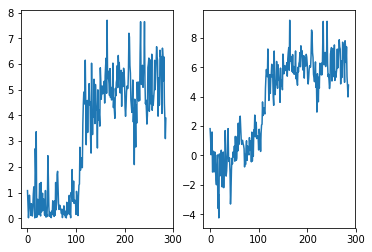

In [36]:
from scipy.stats import ttest_1samp

stat,p = ttest_1samp(diags,popmean=0.5,axis=0)

fig,(ax1,ax2)=plt.subplots(ncols=2)
ax1.plot(-np.log10(p))
ax2.plot(stat)

(286,)

Visualizing group-level matrices 
--

In [6]:
def thresholding(matrix_all,thr=0.65):
    result = np.zeros_like(matrix_all[0])
    mask = np.zeros_like(matrix_all[0])
    
    for curmat in matrix_all:
        mask[curmat>thr] = 1
        result += mask
    return result

In [7]:
def mat_view(curmat,ext,ax1,fig):

    #fig, (ax1) = plt.subplots(ncols=1)
    
    im = ax1.matshow(curmat, figure = fig,cmap='hot', vmin=0,vmax=20,origin='lower',extent = ext)
    ax1.axhline(0., color='k')
    ax1.axvline(0., color='k')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlabel('Testing Time (s)')
    ax1.set_ylabel('Training Time (s)')
    plt.colorbar(im, ax=ax1)
    #return fig,ax1

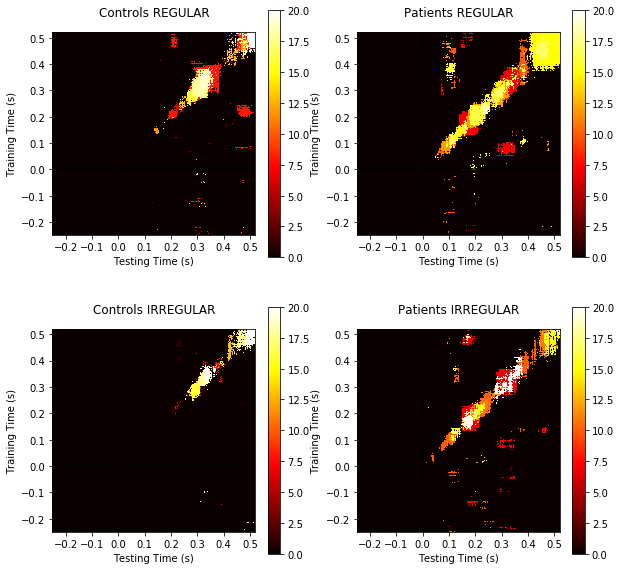

In [176]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
thresh = 0.72


mat_view(thresholding(formal_iso_controls,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Controls REGULAR')

ax=plt.subplot(2,2,2)
mat_view(thresholding(formal_iso_patients,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Patients REGULAR')

ax=plt.subplot(2,2,3)
mat_view(thresholding(formal_rnd_controls,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Controls IRREGULAR')

ax=plt.subplot(2,2,4)
mat_view(thresholding(formal_rnd_patients,thr=thresh),ext = epochsextent,ax1=ax,fig=fig)
plt.title('Patients IRREGULAR')

plt.show()
